In [44]:
# this is just for visual appearance during development, can remove later
from IPython.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>")) 

In [370]:
import requests
import json
import math
import xml.etree.ElementTree as ET
import datetime as dt
import numpy as np
from scipy import optimize
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib import cm





def call_treasury():
    print('Attempting to connect to Treasury...')
    urlvar_data = 'daily_treasury_yield_curve'
    urlvar_year = str(dt.date.today().year)
    url = f'https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data={urlvar_data}&field_tdr_date_value={urlvar_year}'
    response = requests.get(url)
    if response.status_code != 200:
        print(f'An error occured attempting to connect to {response.url}\nCode: {response.status_code} - {response.reason}\n')
        return None
    else:
        print(f'Successfully connected to {response.url}')
        raw_xml_str = response._content.decode('utf-8')
        # parsing treasury xml requires several different namespaces... very annoying
        ns_dict = {'main': raw_xml_str.split('xmlns=')[1].split('"')[1], #  need better solution... this is hacky and vulnerable to changes
                   'd': raw_xml_str.split('xmlns:d=')[1].split('"')[1], 
                   'm': raw_xml_str.split('xmlns:m=')[1].split('"')[1]}
        root = ET.fromstring(raw_xml_str)
        latest_entry = root.findall('main:entry', ns_dict)[-1]
        dt_updated = dt.datetime(*map(int, latest_entry.find('main:updated', ns_dict).text.replace('T','-').replace(':','-')[:-1].split('-')), tzinfo=dt.timezone.utc)
        data_date = dt.date(*map(int, latest_entry.find('main:content/m:properties/d:NEW_DATE', ns_dict).text.split('T')[0].split('-')))
        print(f'Grabbing yield curve data for {data_date} (last updated at {dt_updated} UTC)\n')
        times = [0.0833, 0.1666, 0.25, 0.3333, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]
        par_curve = [(t, float(r.text)/100) for t,r in zip(times, latest_entry.find('main:content/m:properties', ns_dict)[1:-1])]
        return par_curve
    
def call_occ():
    print('\nAttempting to connect to OCC...')
    urlvar_reporttype = 'PR'
    urlvar_optiontype = 'E'
    target_date = dt.date.today()
    urlvar_reportdate = (lambda d: str(d.year)+str(d.month).zfill(2)+str(d.day).zfill(2))(target_date)
    url = f'https://marketdata.theocc.com/flex-reports?reportType={urlvar_reporttype}&optionType={urlvar_optiontype}&reportDate={urlvar_reportdate}'
    response = requests.get(url)
    if response.status_code != 200:
        print(f'An error occured attempting to connect to {response.url}\nCode: {response.status_code} - {response.reason}\n')
        return None
    else:
        print(f'Successfully connected to {response.url}')
        print('Parsing FLEX quotes...')
        flex_quotes = []
        line_splitter = lambda l: [l[1]=='C', dt.date(int(l[4]),int(l[2]),int(l[3])), float(l[5]), float(l[6])]
        for line in response._content.decode('utf-8').splitlines():
            if line=='File requested does not exist.':
                return None
            if('2SPY' in line):
                flex_quotes.append(line_splitter(line.split()))
        return flex_quotes
    
def call_cboe(): # this is the most unstable of all of them... hacky plus they could shut me down at any point
    print('\nAttempting to connect to CBOE...')
    response = requests.get('https://www.cboe.com/delayed_quotes/spy/quote_table/')
    if response.status_code != 200:
        print(f'An error occured attempting to connect to {response.url}\nCode: {response.status_code} - {response.reason}\n')
        return None
    else:
        print(f'Successfully connected to {response.url}')
        print('Parsing SPY option chain...')
        raw = response._content.decode().split('CTX.contextOptionsData = ')[1].split()[0].replace(';','')
        data = json.loads(raw)
        spy_close = float(data['data']['close'])
        symbol_splitter = lambda s: [s[6]=='C', dt.date(int(s[:2])+2000, int(s[2:4]), int(s[4:6])), int(s[7:12])+int(s[12:])/1000]
        chain_quotes = {}
        for q in data['data']['options']:
            if not (q['bid']==0 or q['ask']==0 or q['iv']==0): #exclude one sided quotes and n/a ivol
                sym = symbol_splitter(q['option'].replace('SPY',''))
                days = (sym[1]-dt.date.today()).days
                if days not in chain_quotes.keys():
                    chain_quotes[days] = {}
                if (sym[2] > spy_close) and sym[0]: # otm call
                    chain_quotes[days][sym[2]] = q['iv']
                elif (sym[2] < spy_close) and not sym[0]: # otm put
                    chain_quotes[days][sym[2]] = q['iv']
        return spy_close, chain_quotes
    

def fit_nss_curve(curve_func, known_points):
    guess = [0.02382,0.03002,0.04108,0.05387,0.74504,13.67487] #update periodically
    error_func = lambda params, func, known: sum([(func(k[0],params)-k[1])**2 for k in known])
    result = optimize.minimize(error_func, guess, args=(curve_func, known_points))
    return result['x']
    
def get_rate(t, param):
    a = param[0]+param[1]*(1-math.exp(-t/param[4]))/(t/param[4])
    b = param[2]*((1-math.exp(-t/param[4]))/(t/param[4])-math.exp(-t/param[4]))
    c = param[3]*((1-math.exp(-t/param[5]))/(t/param[5])-math.exp(-t/param[5]))
    return(a+b+c)

def bootstrap_spot(par_params):
    times = np.linspace(0.5,30,60)
    spots = []
    while len(spots)<len(times):
        c = get_rate(times[len(spots)], par_params)/2
        spots.append(((1+c)/(1-sum([c/((1+s)**t) for s,t in zip(spots,times)])))**(1/times[len(spots)])-1)
    return(list(zip(times,spots)))


def gather():
    print(f'Begin data gathering at {dt.datetime.now()}\n')
    par_curve = call_treasury()
    if par_curve:
        print('Fitting par curve...')
        par_params = fit_nss_curve(get_rate, par_curve)
        print('Bootstrapping spot curve...')
        spot_curve = bootstrap_spot(par_params)
        print('Fitting spot curve...')
        spot_params = fit_nss_curve(get_rate, spot_curve)
        
        # -----idk -----
        #print('Excel functions to copy/paste:')
        #print('   Par Curve - appropriate for coupon-paying bonds')
        #excel_parcurve = f'=LAMBDA(t,{par_params[0]:.6f}+{par_params[1]:.6f}*((1-EXP(-t/{par_params[4]:.6f}))/(t/{par_params[4]:.6f}))'+\
        #                 f'+{par_params[2]:.6f}*((1-EXP(-t/{par_params[4]:.6f}))/(t/{par_params[4]:.6f})-EXP(-t/{par_params[4]:.6f}))'+\
        #                 f'+{par_params[3]:.6f}*((1-EXP(-t/{par_params[5]:.6f}))/(t/{par_params[5]:.6f})-EXP(-t/{par_params[5]:.6f})))('
        #print(excel_parcurve)
        #print('   Spot Curve - appropriate for discounting single cashflows')
        #excel_spotcurve = f'=LAMBDA(t,{spot_params[0]:.6f}+{spot_params[1]:.6f}*((1-EXP(-t/{spot_params[4]:.6f}))/(t/{spot_params[4]:.6f}))'+\
        #                  f'+{spot_params[2]:.6f}*((1-EXP(-t/{spot_params[4]:.6f}))/(t/{spot_params[4]:.6f})-EXP(-t/{spot_params[4]:.6f}))'+\
        #                  f'+{spot_params[3]:.6f}*((1-EXP(-t/{spot_params[5]:.6f}))/(t/{spot_params[5]:.6f})-EXP(-t/{spot_params[5]:.6f})))('
        #print(excel_spotcurve)
    flex_quotes = call_occ()
    if flex_quotes:
        print('FLEX quotes caputured successfully')
    spy_close, chain_quotes = call_cboe()

    print(f'\nData gathering complete at {dt.datetime.now()}')
    print('Ready to analyze...')
    return spot_params, flex_quotes, spy_close, chain_quotes



spot_params, flex_quotes, spy_close, chain_quotes = gather()

Begin data gathering at 2023-08-10 14:30:20.771123

Attempting to connect to Treasury...
Successfully connected to https://home.treasury.gov/resource-center/data-chart-center/interest-rates/pages/xml?data=daily_treasury_yield_curve&field_tdr_date_value=2023
Grabbing yield curve data for 2023-08-10 (last updated at 2023-08-10 15:56:01+00:00 UTC)

Fitting par curve...
Bootstrapping spot curve...
Fitting spot curve...

Attempting to connect to OCC...
Successfully connected to https://marketdata.theocc.com/flex-reports?reportType=PR&optionType=E&reportDate=20230810
Parsing FLEX quotes...

Attempting to connect to CBOE...
Successfully connected to https://www.cboe.com/delayed_quotes/spy/quote_table/
Parsing SPY option chain...

Data gathering complete at 2023-08-10 14:30:33.026843
Ready to analyze...


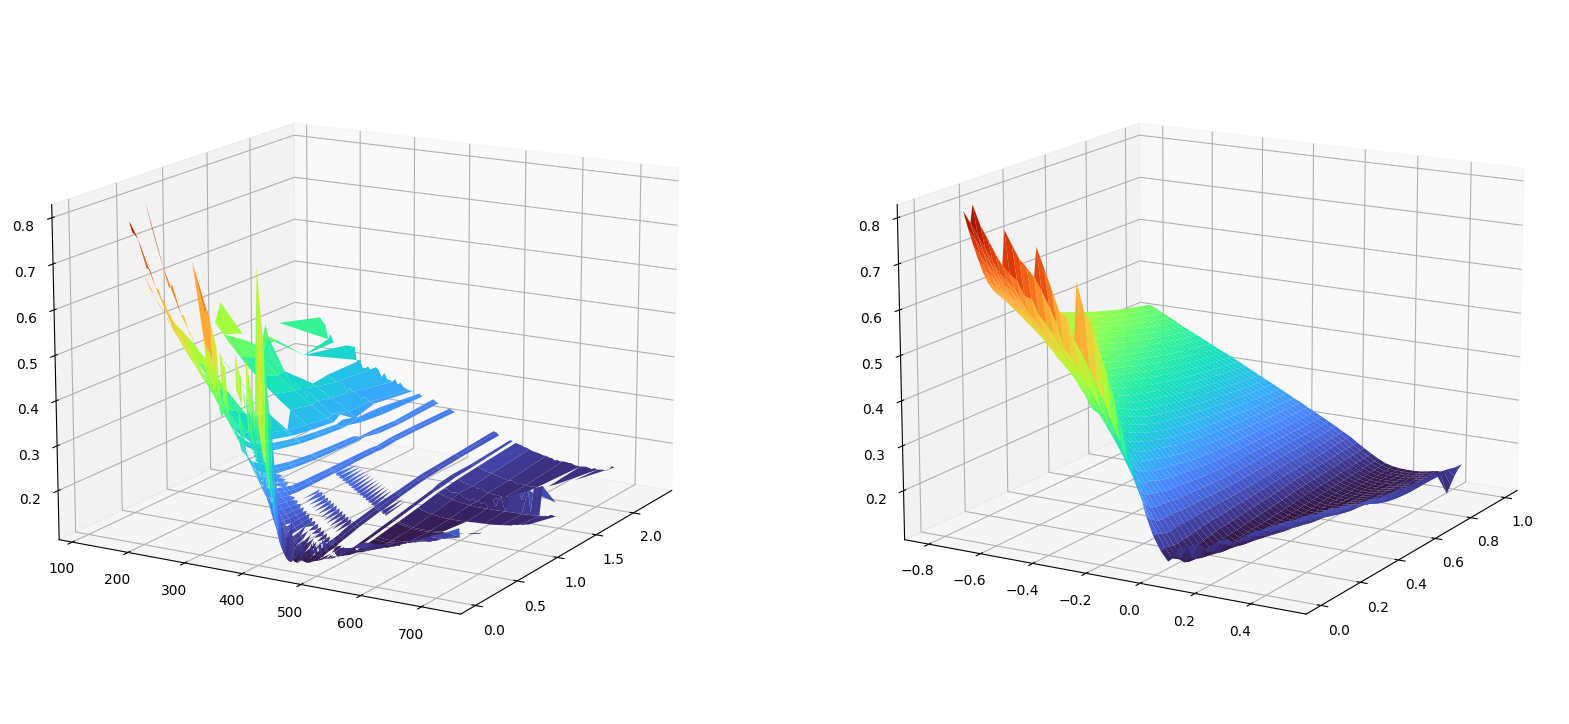

In [371]:
def call_cboe(): # this is the most unstable of all of them... hacky plus they could shut me down at any point
    print('\nAttempting to connect to CBOE...')
    response = requests.get('https://www.cboe.com/delayed_quotes/spy/quote_table/')
    if response.status_code != 200:
        print(f'An error occured attempting to connect to {response.url}\nCode: {response.status_code} - {response.reason}\n')
        return None
    else:
        print(f'Successfully connected to {response.url}')
        print('Parsing SPY option chain...')
        raw = response._content.decode().split('CTX.contextOptionsData = ')[1].split()[0].replace(';','')
        data = json.loads(raw)
        spy_close = float(data['data']['close'])
        symbol_splitter = lambda s: [s[6]=='C', dt.date(int(s[:2])+2000, int(s[2:4]), int(s[4:6])), int(s[7:12])+int(s[12:])/1000]
        chain_quotes = {}
        for q in data['data']['options']:
            if not (q['bid']==0 or q['ask']==0 or q['iv']==0): #exclude one sided quotes and n/a ivol
                sym = symbol_splitter(q['option'].replace('SPY',''))
                days = (sym[1]-dt.date.today()).days
                if days not in chain_quotes.keys():
                    chain_quotes[days] = {}
                if (sym[2] > spy_close) and sym[0]: # otm call
                    chain_quotes[days][sym[2]] = q['iv']
                elif (sym[2] < spy_close) and not sym[0]: # otm put
                    chain_quotes[days][sym[2]] = q['iv']
        return spy_close, chain_quotes
    
def calibrate_vol_surface(spy, quotes, do_plot=True):
    known_points = np.concatenate([[(t/365,math.log(k/spy)) for k in K.keys()] for t,K in quotes.items()])
    known_values = np.concatenate([[v for v in V.values()] for V in quotes.values()])
    query_times = np.linspace(0,1,48)
    query_strikes = np.linspace(-0.8,0.5,48)
    qt, qs = np.meshgrid(query_times,query_strikes)
    query_vols = interpolate.griddata(known_points, known_values, (qt, qs), method='cubic')
    
    
    if do_plot:
        # known data
        plot_df = pd.DataFrame.from_dict(quotes)
        plot_df.sort_index(inplace=True)
        plot_x_ = [t/365 for t in plot_df.columns]
        plot_y_ = [k for k in plot_df.index]
        plot_x, plot_y = np.meshgrid(plot_x_, plot_y_)
        plot_z = np.array([[plot_df.loc[r,c] for c in plot_df.columns] for r in plot_df.index])
        fig = plt.figure(figsize=(20,30))
        ax1 = fig.add_subplot(1,2,1, projection='3d')
        ax1.invert_xaxis()
        ax1.view_init(15, 30)
        ax1.plot_surface(plot_x, plot_y, plot_z, cmap=cm.turbo)
        
        # interpolated data
        ax2 = fig.add_subplot(1,2,2, projection='3d', sharez=ax1)
        ax2.invert_xaxis()
        ax2.view_init(15, 30)
        ax2.plot_surface(qt, qs, query_vols, cmap=cm.turbo)
        plt.show()
        
    return qt, qs, query_vols
    
#spy_close, chain_quotes = call_cboe()
times, strikes, calib = calibrate_vol_surface(spy_close, chain_quotes)

In [366]:
class Fund:
    def __init__(self, ticker, holdings):
        self.ticker = ticker
        self.holdings = holdings
        
        return

class Option:
    def __init__(self, expir, isCall, strike):
        self.expir = expir
        self.isCall = isCall
        self.strike = strike
        
    def mark_from_flex(self):
        
        return

    
holdings_df = pd.read_csv('holdings_230810.csv')
holdings_df['expir'] = pd.to_datetime(holdings_df['expir'])

funds = [Fund(ticker, {Option(holdings_df.loc[pos,'expir'].date(),
                              holdings_df.loc[pos,'call'],
                              holdings_df.loc[pos,'strike']):holdings_df.loc[pos,'qty'] for pos in holdings_df.loc[holdings_df['ticker']==ticker].index
                      }) for ticker in holdings_df['ticker'].unique()]

funds

In [ ]:
#   VERY rough model came from personal research outside of the scope of this project
#   numbers derived from oberservations and several multiple regressions on daily SPY option data from 2005-2021
#   will need to revisit one day, but good enough for now
#   Only applicable/tested at forecast horizons at six months or less!
def forecast_ivol(horizon, time_to_expiration, log_strike, spy_logret, horizon_realized_vol, starting_ivol):
    h = horizon               # year fraction from forecast start to end
    t = time_to_expiration    # year fraction from forecast end to option expiration
    k = log_strike            # ln(strike/(spy at forecast end))
    ds = spy_logret           # ln((spy at forecast end)/(spy at forecast start))
    rv = horizon_realized_vol # standard deviation of daily log returns or spy, annualized at 250 trading days
    v0 = starting_ivol        # option implied volatility at forecast start
    t_ = (-0.0203846*h+0.0000255)*t
    k_ = (0.0179652*h-0.0000261)*k
    ds_ = (1.0569557*h-1.9013248)*ds
    rv_ = (1.159219*h*h-0.80513*h+0.015596)*rv
    i_ = (-0.241939*h*h+0.287693*h)
    dv = math.exp(t_+k_+ds_+rv_+i_)
    return v0*dv

In [ ]:
class Option:
    def __init__(self, expir, isCall, strike):
        self.expir = expir
        self.isCall = isCall
        self.strike = strike
        self.value = 0.0
        self.ivol = 0.0
        
    def mark(self, mark_date, mark_spy, mark_divyld, mark_rate, mark_vol):
        c = 1 if self.isCall else -1
        t = (self.expir-mark_date).days/365
        k = self.strike
        s = mark_spy
        if t <= 0: #expired, return payoff value
            return max(c*(s-k),0)
        q = mark_divyld
        r = mark_rate
        v = mark_vol
        seqt = s*math.exp(-q*t)
        kert = k*math.exp(-r*t)
        d = (math.log(s/k)+t*(r-q+(v**2)/2))/(v*t**0.5)
        return c*seqt*norm.cdf(c*d)-c*kert*norm.cdf(c*(d-v*t**0.5))
    
class Fund:
    def __init__(self, ticker, holdings):
        self.ticker = ticker
        self.holdings = holdings
        
        return

In [187]:
import pandas as pd
import numpy as np

gridvol_df = pd.read_csv('vol_regr_data.csv')

In [188]:
gridvol_df

,date,spy,ret,"t=0.08, k=-0.70","t=0.08, k=-0.60","t=0.08, k=-0.50","t=0.08, k=-0.40","t=0.08, k=-0.30","t=0.08, k=-0.20","t=0.08, k=-0.10",...,"t=1.00, k=-0.50","t=1.00, k=-0.40","t=1.00, k=-0.30","t=1.00, k=-0.20","t=1.00, k=-0.10","t=1.00, k=0.00","t=1.00, k=0.10","t=1.00, k=0.20","t=1.00, k=0.30","t=1.00, k=0.40"
0,2/8/2005,120.21,0.0012,0.9175,0.5570,0.4729,0.4123,0.3804,0.3595,0.3386,...,0.2514,0.2048,0.1819,0.1680,0.1541,0.1464,0.1409,0.1354,0.1333,0.1325
1,2/9/2005,119.31,-0.0075,0.9162,0.5586,0.4786,0.4187,0.3869,0.3640,0.3411,...,0.2542,0.2089,0.1859,0.1700,0.1541,0.1465,0.1414,0.1363,0.1340,0.1326
2,2/10/2005,119.74,0.0036,0.9258,0.5548,0.4764,0.4166,0.3861,0.3632,0.3404,...,0.2553,0.2096,0.1877,0.1721,0.1566,0.1493,0.1442,0.1391,0.1366,0.1347
3,2/11/2005,120.77,0.0086,0.9322,0.5609,0.4781,0.4088,0.3783,0.3561,0.3340,...,0.2540,0.2043,0.1830,0.1677,0.1523,0.1454,0.1402,0.1350,0.1331,0.1318
4,2/14/2005,120.68,-0.0007,0.9014,0.5434,0.4743,0.4062,0.3793,0.3558,0.3324,...,0.2545,0.2034,0.1846,0.1686,0.1525,0.1461,0.1405,0.1349,0.1336,0.1327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,11/23/2021,468.14,0.0016,0.8114,0.6546,0.5900,0.5515,0.5241,0.4993,0.4882,...,0.2261,0.2037,0.1974,0.1835,0.1735,0.1686,0.1628,0.1585,0.1570,0.1549
4228,11/24/2021,469.41,0.0027,0.7974,0.6483,0.5843,0.5458,0.5193,0.4955,0.4838,...,0.2297,0.2061,0.1977,0.1845,0.1745,0.1689,0.1628,0.1581,0.1564,0.1546
4229,11/26/2021,458.97,-0.0225,1.1131,0.7576,0.6808,0.6346,0.7376,0.6456,0.5546,...,0.2177,0.1989,0.3458,0.2618,0.1729,0.1662,0.1584,0.1582,0.1589,0.1575
4230,11/29/2021,464.53,0.0120,0.8423,0.6905,0.6168,0.5700,0.5403,0.5141,0.5020,...,0.2317,0.2056,0.1990,0.1843,0.1729,0.1669,0.1610,0.1568,0.1557,0.1547
